# モデルの学習

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import time

In [2]:
DATAPATH = "../../../data/DBLP/"
OUTPUTPATH = "../../../result/aminer/"

In [3]:
with open(DATAPATH + "keywords.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(1233, 'radiometry')

In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import lightgbm as lgb #LightGBM
from sklearn.metrics import mean_squared_error
from sklearn import utils

from scipy.stats import pearsonr

In [5]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1233, 1233, 23), (1233, 1233), (1233, 1233, 23), (1233, 1233))

In [6]:
N = train_x.shape[0]
M = train_x.shape[1]
N, M

(1233, 1233)

In [7]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((759528, 23), (759528,), (759528, 23), (759528,))

In [8]:
P = train_x.shape[0]
P

759528

In [9]:
model = lgb.LGBMRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))


フィッティング時間: 105.44170717522502
スコア時間: 1.4121138900518417


In [10]:
result_detail = model.predict(test_x)

In [11]:
result = model.predict(test_x)
result_before = model.predict(train_x)
result.shape, result_before.shape

((759528,), (759528,))

In [12]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 14.434, MSE: 208.338, 相関係数: 0.906


In [13]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 9.022, MSE: 81.398, 相関係数: 0.592


In [14]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.28

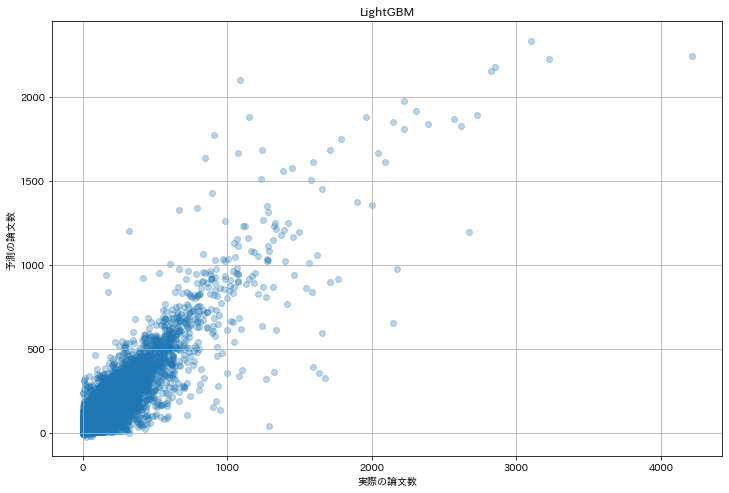

In [15]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

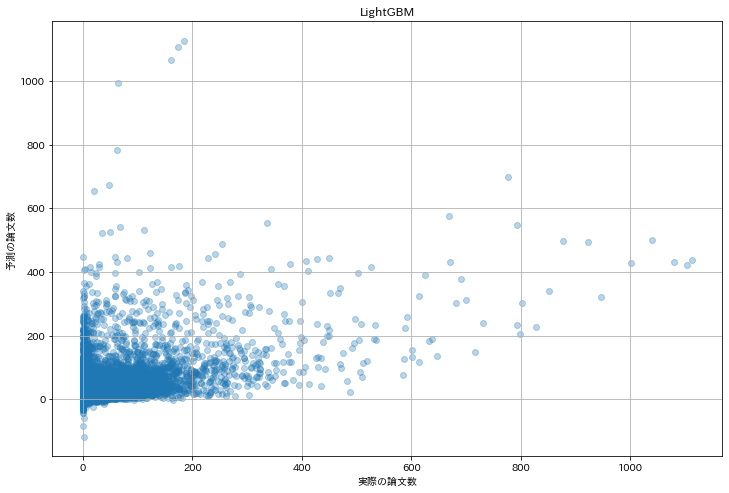

In [16]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [17]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = result_detail
for i in range(N):
    for j in range(N):
        if x[i][j] > 400:
            print(i, j, word_matrix[i][j], correct_matrix[i][j])

10 760 ['monte carlo simulation' 'monte carlo methods'] 4.0
20 32 ['design' 'human factors'] 20.0
20 42 ['design' 'performance'] 173.0
20 65 ['design' 'algorithms'] 161.0
20 97 ['design' 'experimentation'] 48.0
24 65 ['theory' 'algorithms'] 67.0
41 375 ['optimization' 'resource management'] 1103.0
42 65 ['performance' 'algorithms'] 185.0
42 79 ['performance' 'measurement'] 50.0
42 97 ['performance' 'experimentation'] 63.0
50 347 ['bioinformatics' 'proteins'] 58.0
58 125 ['groupware' 'collaboration'] 3.0
65 97 ['algorithms' 'experimentation'] 64.0
65 337 ['algorithms' 'biomedical research'] 0.0
67 367 ['wireless communication' 'wireless sensor networks'] 1112.0
67 428 ['wireless communication' 'interference'] 794.0
73 583 ['sociology' 'statistics'] 777.0
79 97 ['measurement' 'experimentation'] 35.0
104 692 ['robot kinematics' 'mobile robots'] 122.0
110 351 ['mathematical model' 'computational modeling'] 1002.0
155 382 ['mobile computing' 'mobile communication'] 427.0
198 492 ['cloud com

In [18]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if correct_matrix[i][j] < -1500:
            print(i, j, word_matrix[i][j], correct_matrix[i][j])

In [19]:
# # weight = np.load(DATAPATH + "weight.npy")
# weight = np.where(train_y == 0.0, True, False) # if target == 0 : True else: False
# weight_inv = np.where(weight, False, True) # if target == 0 : False else: True

# # 0と1以上のデータを同数にする
# train_x_0, train_y_0 = train_x[weight], train_y[weight]
# train_x_1, train_y_1 = train_x[weight_inv], train_y[weight_inv]
# train_x_0, train_y_0 = utils.shuffle(train_x_0, train_y_0)
# train_x_0, train_y_0 = train_x_0[:len(train_x_1)], train_y_0[:len(train_y_1)]
# train_x, train_y = np.concatenate([train_x_0, train_x_1]), np.concatenate([train_y_0, train_y_1])

# print(train_x.shape, train_y.shape)
# print("0のデータ数: {}, 1以上のデータ数: {}".format(len(train_x_0), len(train_x_1)))

# 人気度

In [20]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y_diff.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1233, 1233, 23), (1233, 1233), (1233, 1233, 23), (1233, 1233))

In [21]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((759528, 23), (759528,), (759528, 23), (759528,))

In [22]:
model = lgb.LGBMRegressor()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))
result = model.predict(test_x)
result_before = model.predict(train_x)

フィッティング時間: 109.26273463666439
スコア時間: 1.4135644473135471


In [23]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 14.424, MSE: 208.066, 相関係数: 0.885


In [24]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 12.432, MSE: 154.545, 相関係数: 0.917


In [25]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.76

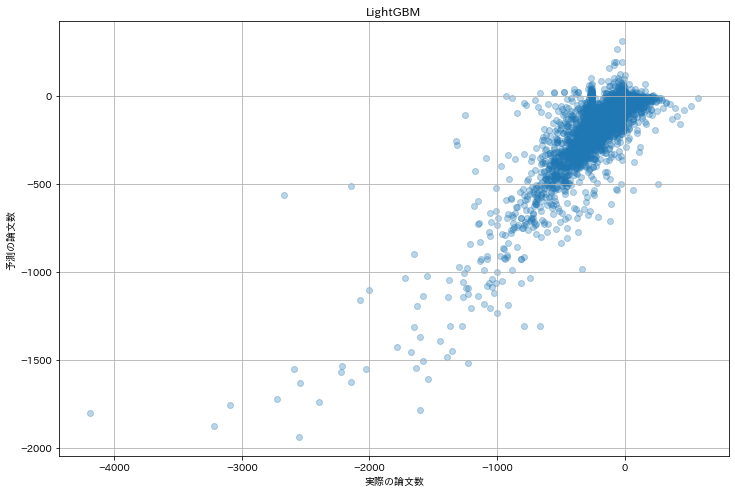

In [26]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
fig.savefig(OUTPUTPATH+"img/gbm_diff.png")
fig.show()

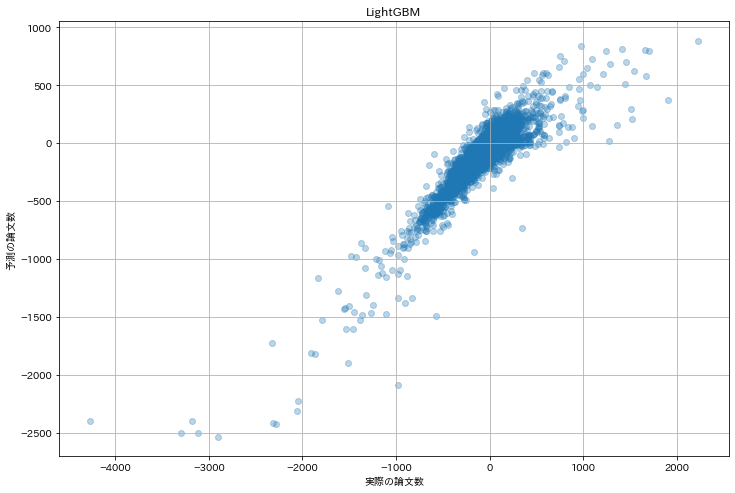

In [27]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("LightGBM")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [28]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if x[i][j] < -1000:
            print(i, j, word_matrix[i][j], correct_matrix[i][j])

17 168 ['internet' 'protocols'] -961.0
17 635 ['internet' 'servers'] -997.0
20 42 ['design' 'performance'] -2000.0
20 65 ['design' 'algorithms'] -1382.0
20 79 ['design' 'measurement'] -1650.0
20 97 ['design' 'experimentation'] -1720.0
25 198 ['resource allocation' 'cloud computing'] -1445.0
25 375 ['resource allocation' 'resource management'] -1672.0
26 1127 ['quality of service' 'qos'] -2074.0
41 365 ['optimization' 'optimisation'] -2144.0
41 421 ['optimization' 'vectors'] -1637.0
42 79 ['performance' 'measurement'] -1605.0
50 65 ['bioinformatics' 'algorithms'] -3219.0
50 315 ['bioinformatics' 'microarrays'] -2217.0
50 337 ['bioinformatics' 'biomedical research'] -2723.0
51 65 ['computational biology' 'algorithms'] -1065.0
65 315 ['algorithms' 'microarrays'] -2222.0
67 367 ['wireless communication' 'wireless sensor networks'] -785.0
77 908 ['energy efficiency' 'energy conservation'] -1231.0
79 97 ['measurement' 'experimentation'] -1548.0
94 305 ['privacy' 'data privacy'] -1026.0
110 3

In [29]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if correct_matrix[i][j] < -1500:
            print(i, j, word_matrix[i][j], correct_matrix[i][j])

20 42 ['design' 'performance'] -2000.0
20 79 ['design' 'measurement'] -1650.0
20 97 ['design' 'experimentation'] -1720.0
25 375 ['resource allocation' 'resource management'] -1672.0
26 1127 ['quality of service' 'qos'] -2074.0
41 365 ['optimization' 'optimisation'] -2144.0
41 421 ['optimization' 'vectors'] -1637.0
42 79 ['performance' 'measurement'] -1605.0
42 97 ['performance' 'experimentation'] -1651.0
50 65 ['bioinformatics' 'algorithms'] -3219.0
50 315 ['bioinformatics' 'microarrays'] -2217.0
50 337 ['bioinformatics' 'biomedical research'] -2723.0
65 315 ['algorithms' 'microarrays'] -2222.0
79 97 ['measurement' 'experimentation'] -1548.0
155 382 ['mobile computing' 'mobile communication'] -2396.0
227 367 ['wireless sensor network' 'wireless sensor networks'] -4194.0
293 431 ['genetic algorithm' 'genetic algorithms'] -2541.0
321 407 ['mimo' 'mimo communication'] -1581.0
341 370 ['feature extraction' 'accuracy'] -1631.0
341 418 ['feature extraction' 'image classification'] -2556.0
34